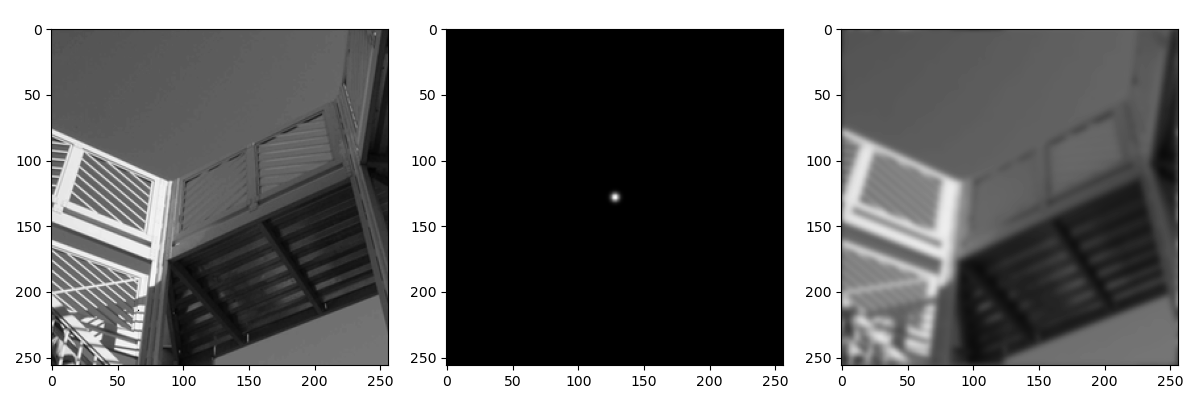

In [1]:
%matplotlib widget
import numpy as np
from numpy.fft import fftshift
import matplotlib.pyplot as plt
from scipy.misc import ascent

import pyopencl as cl
import pyopencl.array as cla
from pyvkfft.opencl import VkFFTApp
from pyvkfft.fft import rfftn, irfftn, fftn, ifftn

cl_ctx = cl.create_some_context()
cq = cl.CommandQueue(cl_ctx)

d = ascent()[:256,:256]
ny, nx = d.shape
y, x = np.meshgrid(np.arange(-ny//2,ny//2), np.arange(-nx//2,nx//2), indexing='ij')
g = np.fft.fftshift(np.exp(-(x**2+y**2)/10))
g /= g.sum()

# Numpy convolution
d, g = d.astype(np.float32), g.astype(np.float32)
gd_np = np.fft.irfftn(np.fft.rfftn(d) * np.fft.rfftn(g))


# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.float32))
g_gpu = cla.to_device(cq,g.astype(np.float32))

# Classic convolution
gd_gpu = irfftn(rfftn(d_gpu) * rfftn(g_gpu))
gd0 = gd_gpu.get()  # Reference result

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d, cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g), cmap='gray')
plt.subplot(133)
plt.imshow(gd_gpu.get(), cmap='gray', vmin=0,vmax=255)
plt.tight_layout()


VkFFTApp[OpenCL]:(256,256+2)     R2C/s/i [rr] [11] buf=    0       0  


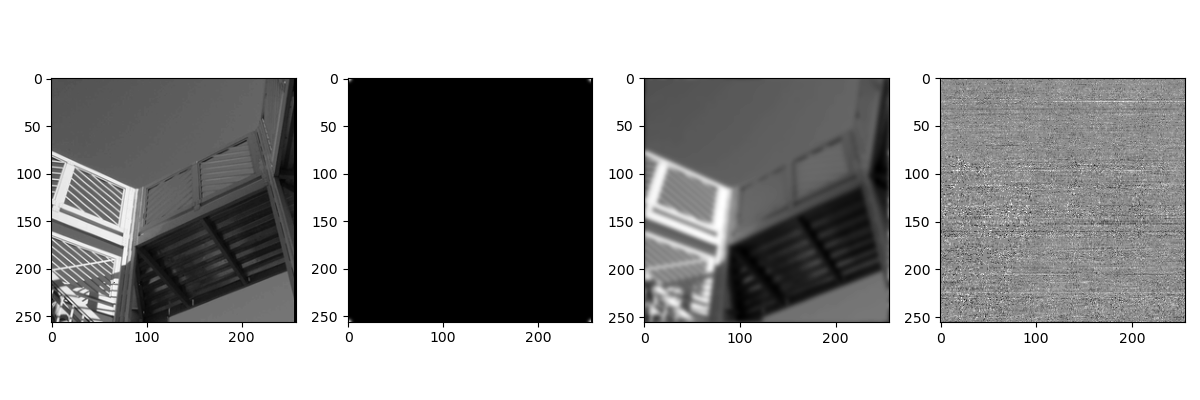

In [2]:
# Inplace R2C with on-the-fly VkFFT convolution
d1 = np.pad(d,((0,0),(0,2)))
g1 = np.pad(g,((0,0),(0,2)))

d_gpu = cla.to_device(cq, d1.astype(np.float32))
g_gpu = cla.to_device(cq, g1.astype(np.float32))

k_gpu = rfftn(g_gpu, g_gpu)

app = VkFFTApp(d1.shape, dtype=np.float32, queue=cq, ndim=2, inplace=True,r2c=True,convolve=True, convolve_conj=0)
app.fft(d_gpu,convolve_kernel=k_gpu)
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(d1, cmap='gray')
plt.subplot(142)
plt.imshow(g1, cmap='gray')
plt.subplot(143)
plt.imshow(d_gpu.get()[:,:-2], cmap='gray')
plt.subplot(144)
plt.imshow(d_gpu.get()[:,:-2]-gd0, cmap='gray')
plt.tight_layout()


VkFFTApp[OpenCL]:(256,256)       C2C/s/i [rr] [11] buf=    0       0  


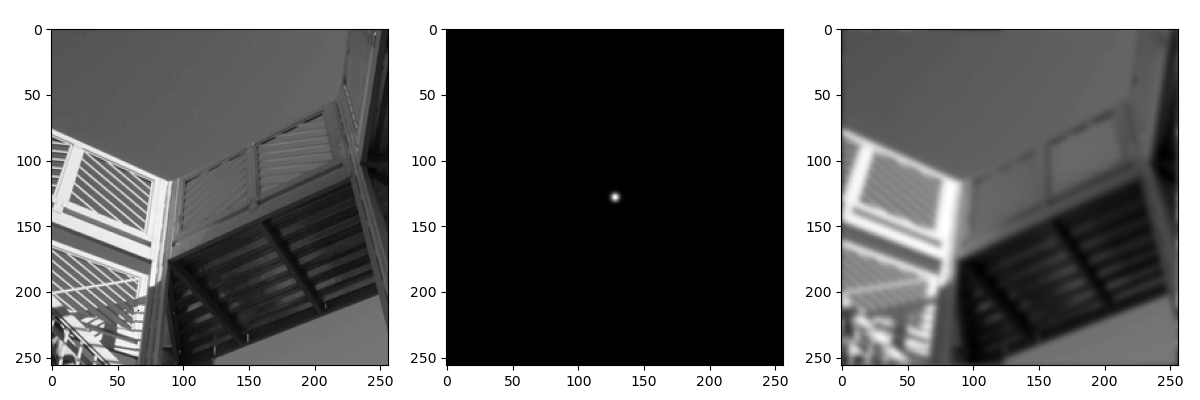

In [3]:
# Inplace C2C VkFFT convolve
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))

k_gpu = fftn(g_gpu)

app = VkFFTApp(d.shape, dtype=np.complex64, queue=cq, ndim=2, inplace=True,convolve=True, convolve_conj=0)
gd_gpu = app.fft(src=d_gpu,convolve_kernel=k_gpu)
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d, cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g), cmap='gray')
plt.subplot(133)
plt.imshow(abs(gd_gpu.get()), cmap='gray')
plt.tight_layout()


VkFFTApp[OpenCL]:(256,256)       C2C/s/o [rr] [11] buf=    0       0  


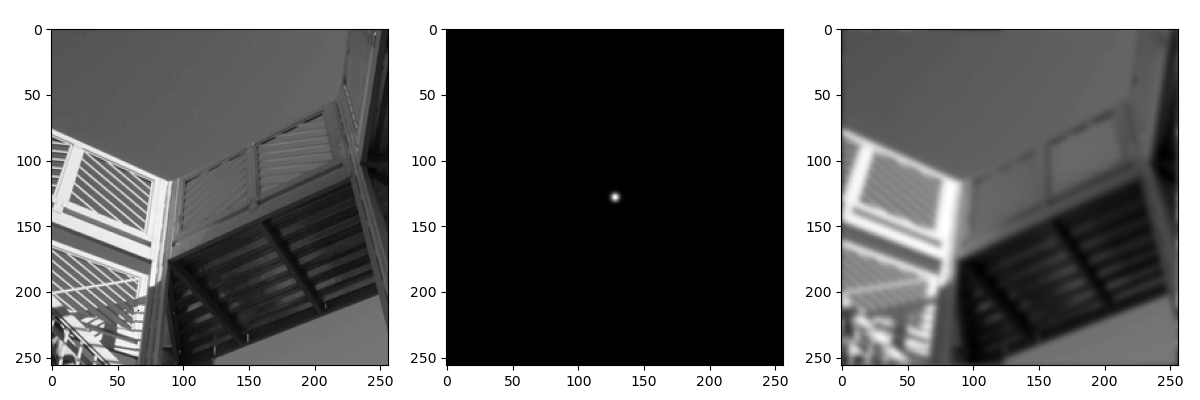

In [4]:
# Out-of-place C2C VkFFT convolve
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))
gd_gpu = cla.empty_like(d_gpu)

k_gpu = fftn(g_gpu)

app = VkFFTApp(d.shape, dtype=np.complex64, queue=cq, ndim=2, inplace=False,convolve=True, convolve_conj=0, convolve_norm=0)
gd_gpu = app.fft(src=d_gpu, dest=gd_gpu,convolve_kernel=k_gpu)
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d, cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g), cmap='gray')
plt.subplot(133)
plt.imshow(abs(gd_gpu.get()), cmap='gray')
plt.tight_layout()


# 1D convolution
Currently all kernel compilations fail in 1D

True

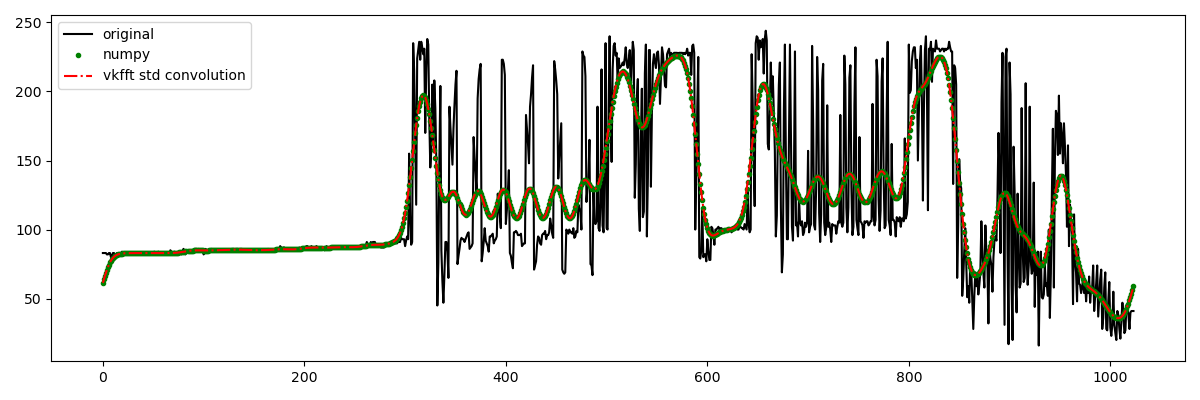

In [16]:
d = ascent()[:256,:4].flatten()
nx = len(d)
x = np.arange(-nx//2,-nx//2+nx)
g = np.fft.fftshift(np.exp(-(x**2)/100))
g /= g.sum()

# Numpy convolution
d, g = d.astype(np.float32), g.astype(np.float32)
gd_np = np.fft.irfftn(np.fft.rfftn(d) * np.fft.rfftn(g))


# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.float32))
g_gpu = cla.to_device(cq,g.astype(np.float32))

# Classic convolution
gd_gpu = irfftn(rfftn(d_gpu) * rfftn(g_gpu))
gd = gd_gpu.get()  # Reference result

plt.figure(figsize=(12,4))
plt.plot(d,'k', label='original')
plt.plot(gd_np,'g.', label='numpy')
plt.plot(gd,'r-.', label='vkfft std convolution')
plt.legend()
plt.tight_layout()

np.allclose(gd, gd_np)

In [17]:
# Inplace R2C VkFFT on-the-fly convolution
# move data to GPU
d_gpu = cla.to_device(cq, np.pad(d,(0,2)))
g_gpu = cla.to_device(cq, np.pad(g,(0,2)))

# VkFFT convolution
k_gpu = rfftn(g_gpu, g_gpu)
app = VkFFTApp(d_gpu.shape, dtype=np.float32, ndim=1, queue=cq, inplace=True,r2c=True,convolve=True, convolve_conj=0)
gd = app.fft(d_gpu,convolve_kernel=k_gpu).get()
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.plot(d,'k', label='original')
plt.plot(gd_np,'g.', label='numpy')
plt.plot(gd,'r-.', label='vkfft std convolution')
plt.legend()
plt.tight_layout()

np.allclose(gd0, gd_np)

program_source:1847:2: error: expected '}'
}
 ^
program_source:1021:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1847:2: error: expected '}'
}
 ^
program_source:1000:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1847:2: error: expected '}'
}
 ^
program_source:979:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1847:2: error: expected '}'
}
 ^
program_source:958:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1847:2: error: expected '}'
}
 ^
program_source:937:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1847:2: error: expected '}'
}
 ^
program_source:916:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1847:2: error: expected '}'
}
 ^
program_source:895:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1847:2: error: expected 

UNSUPPORTED (log once): buildComputeProgram: cl2Metal failed


RuntimeError: VkFFT error 4031: VKFFT_ERROR_FAILED_TO_COMPILE_PROGRAM R2C (1024+2) <class 'numpy.float32'> 1D inplace norm=1 [opencl:Apple:Apple M1 Pro]

 = native_sin(angle);
loc_0.x = temp_4.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_4.x, w.x, loc_0.x);
loc_0.y = temp_4.y * w.x;
loc_0.y = fma(temp_4.x, w.y, loc_0.y);
temp_4.x = temp_0.x - loc_0.x;
temp_4.y = temp_0.y - loc_0.y;
temp_0.x = temp_0.x + loc_0.x;
temp_0.y = temp_0.y + loc_0.y;
loc_0.x = temp_5.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_5.x, w.x, loc_0.x);
loc_0.y = temp_5.y * w.x;
loc_0.y = fma(temp_5.x, w.y, loc_0.y);
temp_5.x = temp_1.x - loc_0.x;
temp_5.y = temp_1.y - loc_0.y;
temp_1.x = temp_1.x + loc_0.x;
temp_1.y = temp_1.y + loc_0.y;
loc_0.x = temp_6.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_6.x, w.x, loc_0.x);
loc_0.y = temp_6.y * w.x;
loc_0.y = fma(temp_6.x, w.y, loc_0.y);
temp_6.x = temp_2.x - loc_0.x;
temp_6.y = temp_2.y - loc_0.y;
temp_2.x = temp_2.x + loc_0.x;
temp_2.y = temp_2.y + loc_0.y;
loc_0.x = temp_7.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_7.x, w.x, loc_0.x);
loc_0.y = temp_7.y * w.x;
loc_0.y = fma(temp_7.x, w.y, loc_0.y);
temp_7

In [18]:
d.shape, g.shape

((1024,), (1024,))

In [25]:
# Inplace C2C VkFFT on-the-fly convolution
# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))

# VkFFT convolution
k_gpu = fftn(g_gpu, g_gpu)
app = VkFFTApp(d_gpu.shape, dtype=np.complex64, ndim=1, queue=cq, inplace=True,convolve=True, convolve_conj=0)
gd = app.fft(d_gpu,convolve_kernel=k_gpu).get().real
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.plot(d,'k', label='original')
plt.plot(gd_np,'g.', label='numpy')
plt.plot(gd,'r-.', label='vkfft std convolution')
plt.legend()
plt.tight_layout()

np.allclose(gd0, gd_np)

 blockInvocationID * 8;
inoutID = inoutID + stageInvocationID;
sdataID = inoutID + 0;
sdata[sdataID] = temp_0;
sdataID = inoutID + 64;
sdata[sdataID] = temp_1;
sdataID = inoutID + 128;
sdata[sdataID] = temp_2;
sdataID = inoutID + 192;
sdata[sdataID] = temp_3;
sdataID = inoutID + 256;
sdata[sdataID] = temp_4;
sdataID = inoutID + 320;
sdata[sdataID] = temp_5;
sdataID = inoutID + 384;
sdata[sdataID] = temp_6;
sdataID = inoutID + 448;
sdata[sdataID] = temp_7;
barrier(CLK_LOCAL_MEM_FENCE);

stageInvocationID = get_local_id(0) + 0;
stageInvocationID = stageInvocationID % 512;
angle = stageInvocationID * 6.13592315154256468e-03f;
sdataID = get_local_id(0) + 0;
temp_0 = sdata[sdataID];
sdataID = get_local_id(0) + 512;
temp_4 = sdata[sdataID];
w.x = native_cos(angle);
w.y = native_sin(angle);
loc_0.x = temp_4.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_4.x, w.x, loc_0.x);
loc_0.y = temp_4.y * w.x;
loc_0.y = fma(temp_4.x, w.y, loc_0.y);
temp_4.x = temp_0.x - loc_0.x;
temp_4.y = temp_0.y - lo

RuntimeError: VkFFT error 4031: VKFFT_ERROR_FAILED_TO_COMPILE_PROGRAM C2C (1024,) <class 'numpy.complex64'> 1D inplace norm=1 [opencl:Apple:Apple M1 Pro]

xpected '}'
}
 ^
program_source:967:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1769:2: error: expected '}'
}
 ^
program_source:946:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1769:2: error: expected '}'
}
 ^
program_source:925:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1769:2: error: expected '}'
}
 ^
program_source:904:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1769:2: error: expected '}'
}
 ^
program_source:883:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1769:2: error: expected '}'
}
 ^
program_source:862:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1769:2: error: expected '}'
}
 ^
program_source:841:20: note: to match this '{'
if (inoutID_y < 1) {
                   ^
program_source:1769:2: error: expected '}'
}
 ^
program_source:1:156: no

In [26]:
# Out-of-place C2C VkFFT on-the-fly convolution
# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))
gd_gpu = cla.empty_like(d_gpu)

# VkFFT convolution
k_gpu = fftn(g_gpu, g_gpu)
app = VkFFTApp(d_gpu.shape, dtype=np.complex64, ndim=1, queue=cq, inplace=False,convolve=True, convolve_conj=0)
gd = app.fft(d_gpu, gd_gpu,convolve_kernel=k_gpu).get().real
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.plot(d,'k', label='original')
plt.plot(gd_np,'g.', label='numpy')
plt.plot(gd,'r-.', label='vkfft std convolution')
plt.legend()
plt.tight_layout()

np.allclose(gd0, gd_np)

 / 16;
tempInt = tempInt * 17;
sdataID = sdataID % 16;
sdataID = sdataID + tempInt;
temp_5 = sdata[sdataID];
sdataID = get_local_id(0) + 768;
tempInt = sdataID / 16;
tempInt = tempInt * 17;
sdataID = sdataID % 16;
sdataID = sdataID + tempInt;
temp_3 = sdata[sdataID];
sdataID = get_local_id(0) + 896;
tempInt = sdataID / 16;
tempInt = tempInt * 17;
sdataID = sdataID % 16;
sdataID = sdataID + tempInt;
temp_7 = sdata[sdataID];
w.x = native_cos(angle);
w.y = native_sin(angle);
loc_0.x = temp_1.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_1.x, w.x, loc_0.x);
loc_0.y = temp_1.y * w.x;
loc_0.y = fma(temp_1.x, w.y, loc_0.y);
temp_1.x = temp_0.x - loc_0.x;
temp_1.y = temp_0.y - loc_0.y;
temp_0.x = temp_0.x + loc_0.x;
temp_0.y = temp_0.y + loc_0.y;
loc_0.x = temp_5.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_5.x, w.x, loc_0.x);
loc_0.y = temp_5.y * w.x;
loc_0.y = fma(temp_5.x, w.y, loc_0.y);
temp_5.x = temp_4.x - loc_0.x;
temp_5.y = temp_4.y - loc_0.y;
temp_4.x = temp_4.x + loc_0.x;
temp_4

RuntimeError: VkFFT error 4031: VKFFT_ERROR_FAILED_TO_COMPILE_PROGRAM C2C (1024,) <class 'numpy.complex64'> 1D norm=1 [opencl:Apple:Apple M1 Pro]

geInvocationID = stageInvocationID % 512;
angle = stageInvocationID * 6.13592315154256468e-03f;
sdataID = get_local_id(0) + 0;
temp_0 = sdata[sdataID];
sdataID = get_local_id(0) + 512;
temp_4 = sdata[sdataID];
w.x = native_cos(angle);
w.y = native_sin(angle);
loc_0.x = temp_4.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_4.x, w.x, loc_0.x);
loc_0.y = temp_4.y * w.x;
loc_0.y = fma(temp_4.x, w.y, loc_0.y);
temp_4.x = temp_0.x - loc_0.x;
temp_4.y = temp_0.y - loc_0.y;
temp_0.x = temp_0.x + loc_0.x;
temp_0.y = temp_0.y + loc_0.y;
stageInvocationID = get_local_id(0) + 128;
stageInvocationID = stageInvocationID % 512;
angle = stageInvocationID * 6.13592315154256468e-03f;
sdataID = get_local_id(0) + 128;
temp_1 = sdata[sdataID];
sdataID = get_local_id(0) + 640;
temp_5 = sdata[sdataID];
w.x = native_cos(angle);
w.y = native_sin(angle);
loc_0.x = temp_5.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_5.x, w.x, loc_0.x);
loc_0.y = temp_5.y * w.x;
loc_0.y = fma(temp_5.x, w.y, loc_0.y);
temp_5.x

# Batch 1D convolution
same as non-batched 1D - does not compile

True

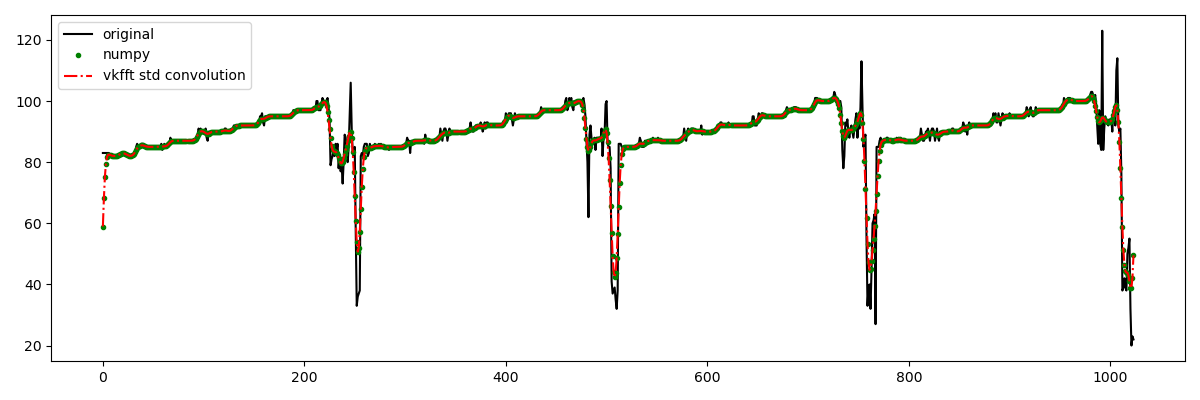

In [32]:
d = ascent()[:256:16,:256].reshape((4,1024))
ny, nx = d.shape
y, x = np.meshgrid(np.arange(-ny//2,ny//2), np.arange(-nx//2,nx//2), indexing='ij')
g = np.fft.fftshift(np.exp(-(x**2)/10))
g /= g[0].sum()

# Numpy convolution
d, g = d.astype(np.float32), g.astype(np.float32)
gd_np = np.fft.irfftn(np.fft.rfftn(d,axes=(-1,)) * np.fft.rfftn(g, axes=(-1,)), axes=(-1,))

# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.float32))
g_gpu = cla.to_device(cq,g.astype(np.float32))

# Classic convolution
gd_gpu = irfftn(rfftn(d_gpu, ndim=1) * rfftn(g_gpu, ndim=1), ndim=1)
gd = gd_gpu.get()  # Reference result

plt.figure(figsize=(12,4))
plt.plot(d[0],'k', label='original')
plt.plot(gd_np[0],'g.', label='numpy')
plt.plot(gd[0],'r-.', label='vkfft std convolution')
plt.legend()
plt.tight_layout()

np.allclose(gd, gd_np)

In [30]:
# Inplace R2C VkFFT on-the-fly convolution
# move data to GPU
d_gpu = cla.to_device(cq, np.pad(d,((0,0),(0,2))))
g_gpu = cla.to_device(cq, np.pad(g,((0,0),(0,2))))

# VkFFT convolution
k_gpu = rfftn(g_gpu, g_gpu, ndim=1)
app = VkFFTApp(d_gpu.shape, dtype=np.float32, ndim=1, queue=cq, inplace=True,r2c=True,convolve=True, convolve_conj=0)
gd = app.fft(d_gpu,convolve_kernel=k_gpu).get()
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(12,4))
plt.plot(d[0],'k', label='original')
plt.plot(gd_np[0],'g.', label='numpy')
plt.plot(gd[0],'r-.', label='vkfft std convolution')
plt.legend()
plt.tight_layout()

np.allclose(gd0, gd_np)

CAL_MEM_FENCE);

stageInvocationID = get_local_id(0) + 0;
blockInvocationID = stageInvocationID;
stageInvocationID = stageInvocationID % 8;
blockInvocationID = blockInvocationID - stageInvocationID;
inoutID = blockInvocationID * 8;
inoutID = inoutID + stageInvocationID;
sdataID = inoutID + 0;
tempInt = sdataID / 16;
tempInt = tempInt * 17;
sdataID = sdataID % 16;
sdataID = sdataID + tempInt;
sdata[sdataID] = temp_0;
sdataID = inoutID + 8;
tempInt = sdataID / 16;
tempInt = tempInt * 17;
sdataID = sdataID % 16;
sdataID = sdataID + tempInt;
sdata[sdataID] = temp_4;
sdataID = inoutID + 16;
tempInt = sdataID / 16;
tempInt = tempInt * 17;
sdataID = sdataID % 16;
sdataID = sdataID + tempInt;
sdata[sdataID] = temp_2;
sdataID = inoutID + 24;
tempInt = sdataID / 16;
tempInt = tempInt * 17;
sdataID = sdataID % 16;
sdataID = sdataID + tempInt;
sdata[sdataID] = temp_6;
sdataID = inoutID + 32;
tempInt = sdataID / 16;
tempInt = tempInt * 17;
sdataID = sdataID % 16;
sdataID = sdataID + tempInt;
sdata[

RuntimeError: VkFFT error 4031: VKFFT_ERROR_FAILED_TO_COMPILE_PROGRAM R2C (4,1024+2) <class 'numpy.float32'> 1D inplace norm=1 [opencl:Apple:Apple M1 Pro]

0.x;
loc_0.x = fma(temp_1.x, w.x, loc_0.x);
loc_0.y = temp_1.y * w.x;
loc_0.y = fma(temp_1.x, w.y, loc_0.y);
temp_1.x = temp_0.x - loc_0.x;
temp_1.y = temp_0.y - loc_0.y;
temp_0.x = temp_0.x + loc_0.x;
temp_0.y = temp_0.y + loc_0.y;
loc_0.x = temp_5.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_5.x, w.x, loc_0.x);
loc_0.y = temp_5.y * w.x;
loc_0.y = fma(temp_5.x, w.y, loc_0.y);
temp_5.x = temp_4.x - loc_0.x;
temp_5.y = temp_4.y - loc_0.y;
temp_4.x = temp_4.x + loc_0.x;
temp_4.y = temp_4.y + loc_0.y;
loc_0.x = temp_3.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_3.x, w.x, loc_0.x);
loc_0.y = temp_3.y * w.x;
loc_0.y = fma(temp_3.x, w.y, loc_0.y);
temp_3.x = temp_2.x - loc_0.x;
temp_3.y = temp_2.y - loc_0.y;
temp_2.x = temp_2.x + loc_0.x;
temp_2.y = temp_2.y + loc_0.y;
loc_0.x = temp_7.y * w.y;
loc_0.x = -loc_0.x;
loc_0.x = fma(temp_7.x, w.x, loc_0.x);
loc_0.y = temp_7.y * w.x;
loc_0.y = fma(temp_7.x, w.y, loc_0.y);
temp_7.x = temp_6.x - loc_0.x;
temp_7.y = temp_6.y - loc_0.y;
temp_6.

# 3D convolution
results are incorrect

True

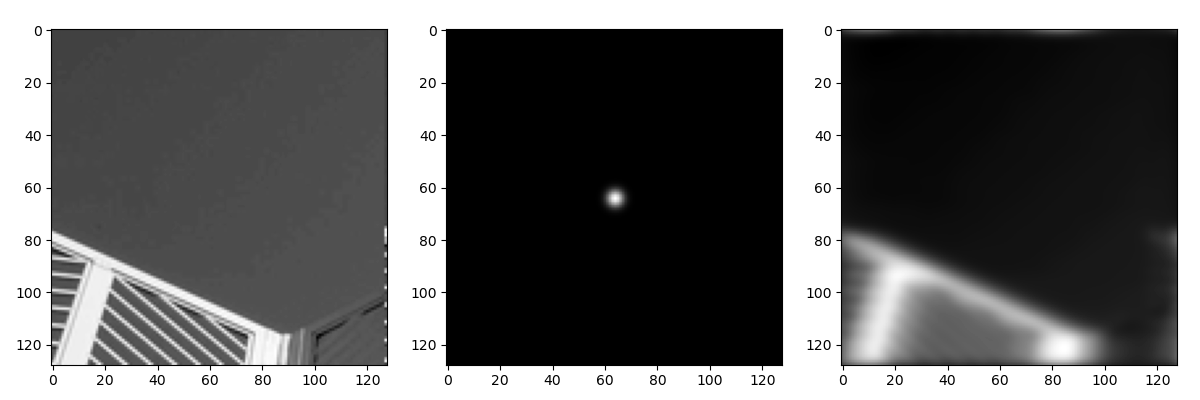

In [18]:
n = 128
d = np.empty((n,n,n),dtype=np.float32)
# Random shift for each layer to make sure transform is not trivial
for i in range(n):
    d[i] = np.roll(ascent()[:n,:n], np.random.randint(-10,10,2))
nz, ny, nx = d.shape
z, y, x = np.meshgrid(np.arange(-nz//2,nz//2), np.arange(-ny//2,ny//2), np.arange(-nx//2,nx//2), indexing='ij')
g = np.fft.fftshift(np.exp(-(x**2+y**2+z**2)/10))
g /= g.sum()

# Numpy convolution
d, g = d.astype(np.float32), g.astype(np.float32)
gd_np = np.fft.irfftn(np.fft.rfftn(d) * np.fft.rfftn(g))

# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.float32))
g_gpu = cla.to_device(cq,g.astype(np.float32))

# Classic convolution
gd_gpu = irfftn(rfftn(d_gpu) * rfftn(g_gpu))
gd = gd_gpu.get()  # Reference result

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d[n//2], cmap='gray')
plt.subplot(132)
plt.imshow(np.fft.fftshift(g)[n//2], cmap='gray')
plt.subplot(133)
plt.imshow(gd[n//2], cmap='gray')
plt.tight_layout()

np.allclose(gd, gd_np)

VkFFTApp[OpenCL]:(128,128,128+2) R2C/s/i [rrr] [111] buf=    0       0  


False

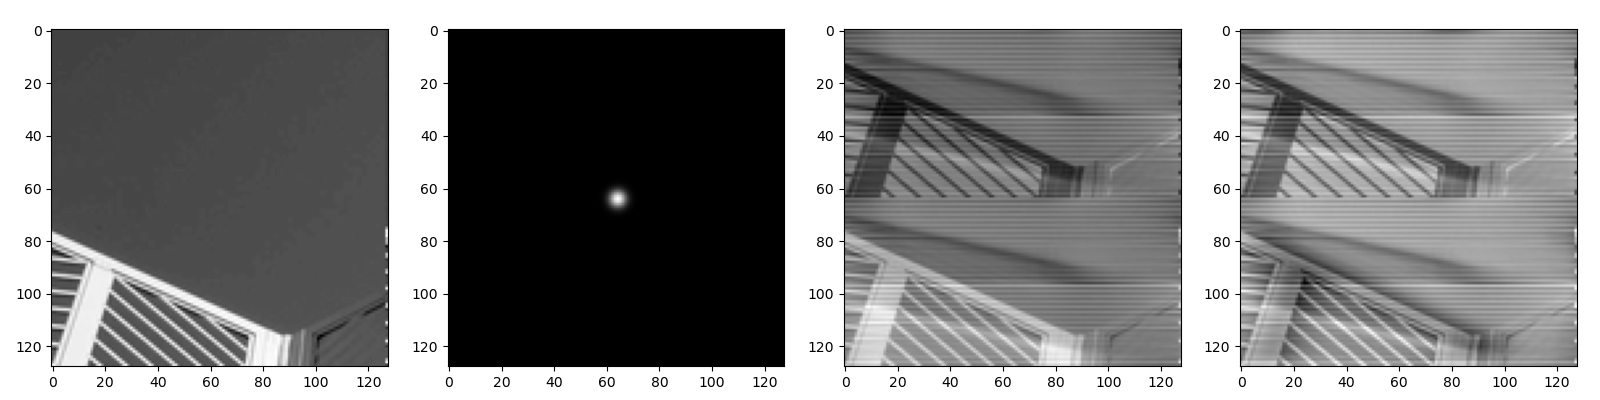

In [19]:
# Using inplace R2C VkFFT on-the-fly transform

# move data to GPU
d_gpu = cla.to_device(cq, np.pad(d,((0,0),(0,0),(0,2))))
g_gpu = cla.to_device(cq, np.pad(g,((0,0),(0,0),(0,2))))

k_gpu = rfftn(g_gpu, g_gpu)

app = VkFFTApp(d_gpu.shape, dtype=np.float32, queue=cq, ndim=3, inplace=True,r2c=True,convolve=True, convolve_conj=0)
gd = app.fft(d_gpu,convolve_kernel=k_gpu).get()
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(d[n//2], cmap='gray')
plt.subplot(142)
plt.imshow(np.fft.fftshift(g)[n//2], cmap='gray')
plt.subplot(143)
plt.imshow(gd[n//2,:,:-2], cmap='gray')
plt.subplot(144)
plt.imshow(gd[n//2,:,:-2]-gd_np[n//2], cmap='gray')
plt.tight_layout()

np.allclose(gd[..., :-2], gd_np)

VkFFTApp[OpenCL]:(128,128,128)   C2C/s/i [rrr] [111] buf=    0       0  


False

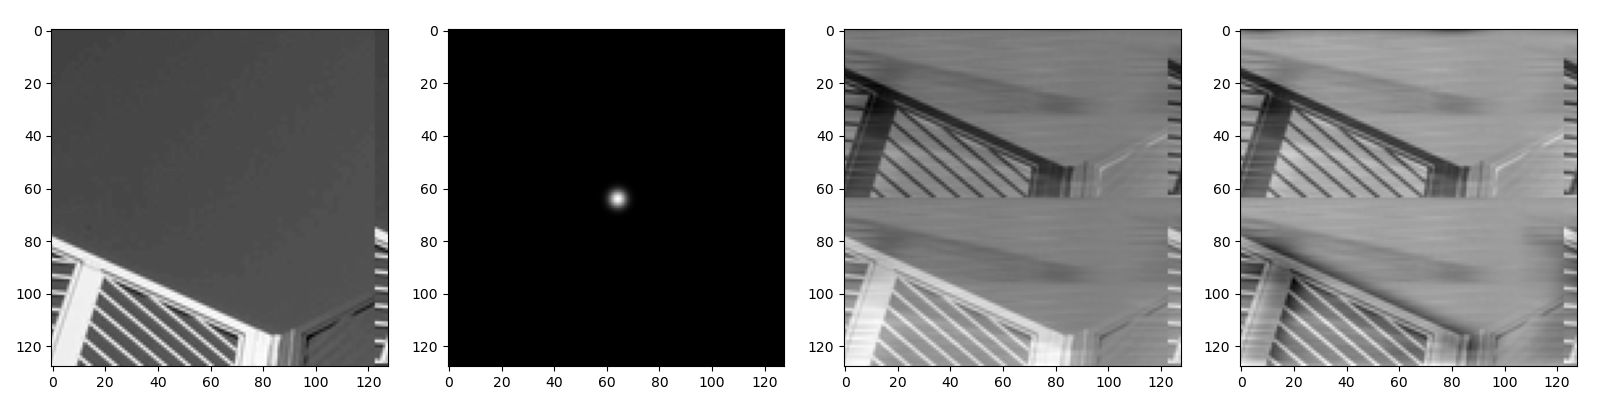

In [48]:
# Using inplace C2C VkFFT on-the-fly transform

# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))

k_gpu = fftn(g_gpu, g_gpu)

app = VkFFTApp(d_gpu.shape, dtype=np.complex64, queue=cq, ndim=3, inplace=True,convolve=True, convolve_conj=0)
gd = app.fft(d_gpu,convolve_kernel=k_gpu).get().real
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(d[n//2], cmap='gray')
plt.subplot(142)
plt.imshow(np.fft.fftshift(g)[n//2], cmap='gray')
plt.subplot(143)
plt.imshow(gd[n//2], cmap='gray')
plt.subplot(144)
plt.imshow(gd[n//2]-gd_np[n//2], cmap='gray')
plt.tight_layout()

np.allclose(gd, gd_np)

VkFFTApp[OpenCL]:(128,128,128)   C2C/s/o [rrr] [111] buf=    0       0  


False

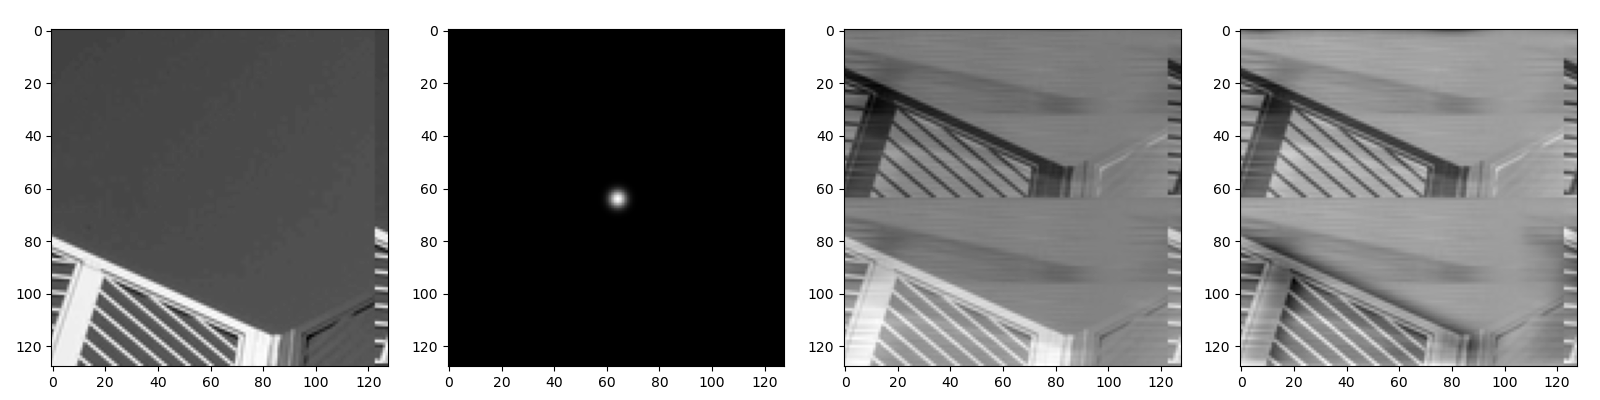

In [52]:
# Using out-of-place C2C VkFFT on-the-fly transform

# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))
gd_gpu = cla.empty_like(d_gpu)

k_gpu = fftn(g_gpu, g_gpu)

app = VkFFTApp(d_gpu.shape, dtype=np.complex64, queue=cq, ndim=3, inplace=False,convolve=True, convolve_conj=0)
gd = app.fft(d_gpu, gd_gpu,convolve_kernel=k_gpu).get().real
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(d[n//2], cmap='gray')
plt.subplot(142)
plt.imshow(np.fft.fftshift(g)[n//2], cmap='gray')
plt.subplot(143)
plt.imshow(gd[n//2], cmap='gray')
plt.subplot(144)
plt.imshow(gd[n//2]-gd_np[n//2], cmap='gray')
plt.tight_layout()

np.allclose(gd, gd_np)

# Batch 2D convolution
works by putting the batch number in VkFFT's ``coordinateFeatures`` instead of numberBatches

True

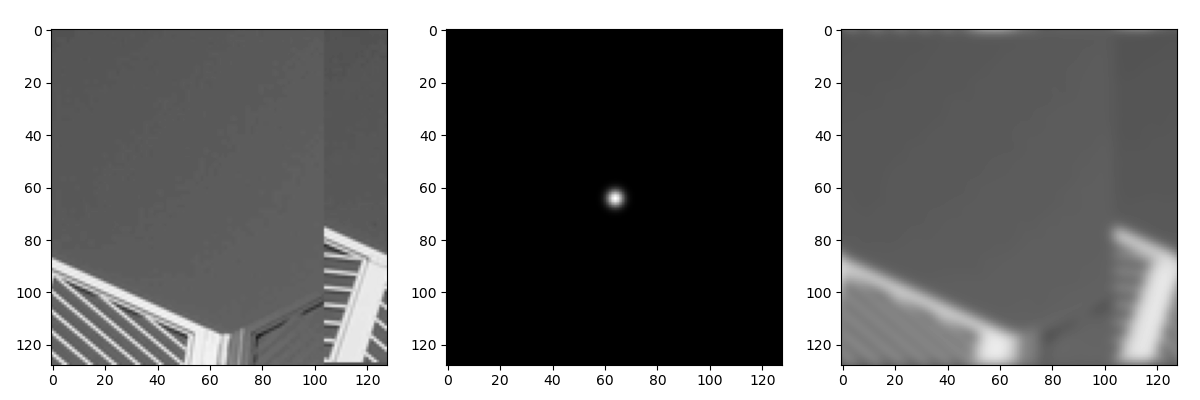

In [11]:
n = 128
d = np.empty((n,n,n),dtype=np.float32)
# Random shift for each layer to make sure transform is not trivial
for i in range(n):
    d[i] = np.roll(ascent()[:n,:n], np.random.randint(-40,40,2))
nz, ny, nx = d.shape
z, y, x = np.meshgrid(np.arange(-nz//2,nz//2), np.arange(-ny//2,ny//2), np.arange(-nx//2,nx//2), indexing='ij')
g = np.fft.fftshift(np.exp(-(x**2+y**2)/10))
g /= g[0].sum()

# Numpy convolution
d, g = d.astype(np.float32), g.astype(np.float32)
gd_np = np.fft.irfftn(np.fft.rfftn(d, axes=(-1,-2)) * np.fft.rfftn(g, axes=(-1,-2)), axes=(-1,-2))

# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.float32))
g_gpu = cla.to_device(cq,g.astype(np.float32))

# Classic convolution
gd_gpu = irfftn(rfftn(d_gpu, ndim=2) * rfftn(g_gpu, ndim=2), ndim=2)
gd = gd_gpu.get()  # Reference result

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(d[n//2], cmap='gray',vmin=0,vmax=255)
plt.subplot(132)
plt.imshow(np.fft.fftshift(g)[n//2], cmap='gray')
plt.subplot(133)
plt.imshow(gd[n//2], cmap='gray',vmin=0,vmax=255)
plt.tight_layout()

np.allclose(gd, gd_np)

VkFFTApp[OpenCL]:(128,128,128+2) R2C/s/i [-rr] [011] buf=    0       0  


True

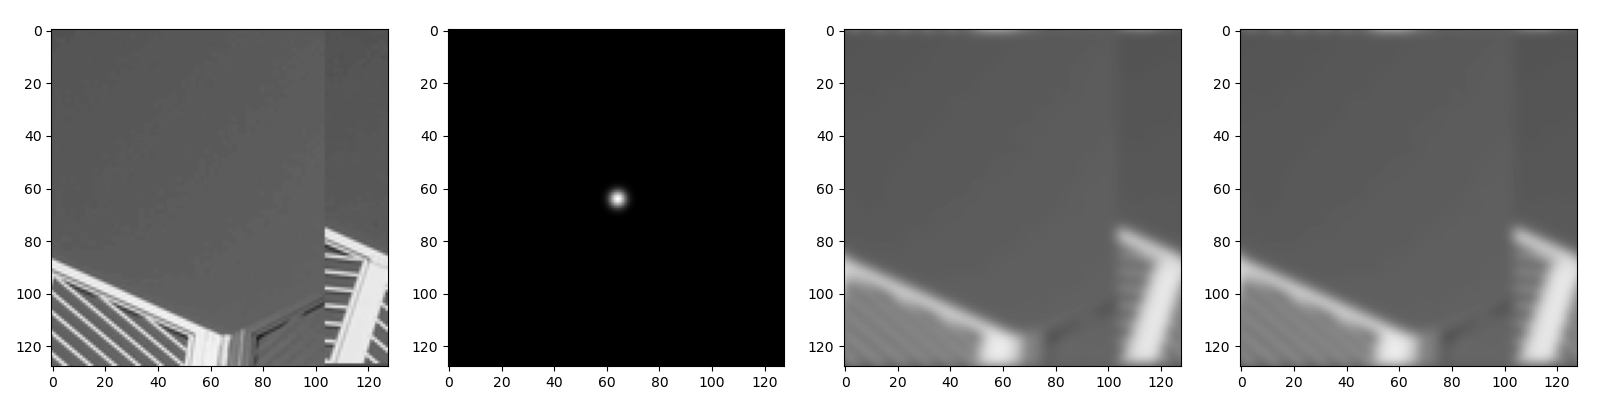

In [12]:
# Using inplace R2C VkFFT on-the-fly transform

# move data to GPU
d_gpu = cla.to_device(cq, np.pad(d,((0,0),(0,0),(0,2))))
g_gpu = cla.to_device(cq, np.pad(g,((0,0),(0,0),(0,2))))

k_gpu = rfftn(g_gpu, g_gpu, ndim=2)

app = VkFFTApp(d_gpu.shape, dtype=np.float32, queue=cq, ndim=2, inplace=True,r2c=True,convolve=True, convolve_conj=0)
gd = app.fft(d_gpu,convolve_kernel=k_gpu).get()
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(d[n//2], cmap='gray',vmin=0,vmax=255)
plt.subplot(142)
plt.imshow(np.fft.fftshift(g)[n//2], cmap='gray')
plt.subplot(143)
plt.imshow(gd[n//2,:,:-2], cmap='gray',vmin=0,vmax=255)
plt.subplot(144)
plt.imshow(gd_np[n//2], cmap='gray',vmin=0,vmax=255)
plt.tight_layout()

np.allclose(gd[..., :-2], gd_np)

VkFFTApp[OpenCL]:(128,128,128)   C2C/s/i [-rr] [011] buf=    0       0  


True

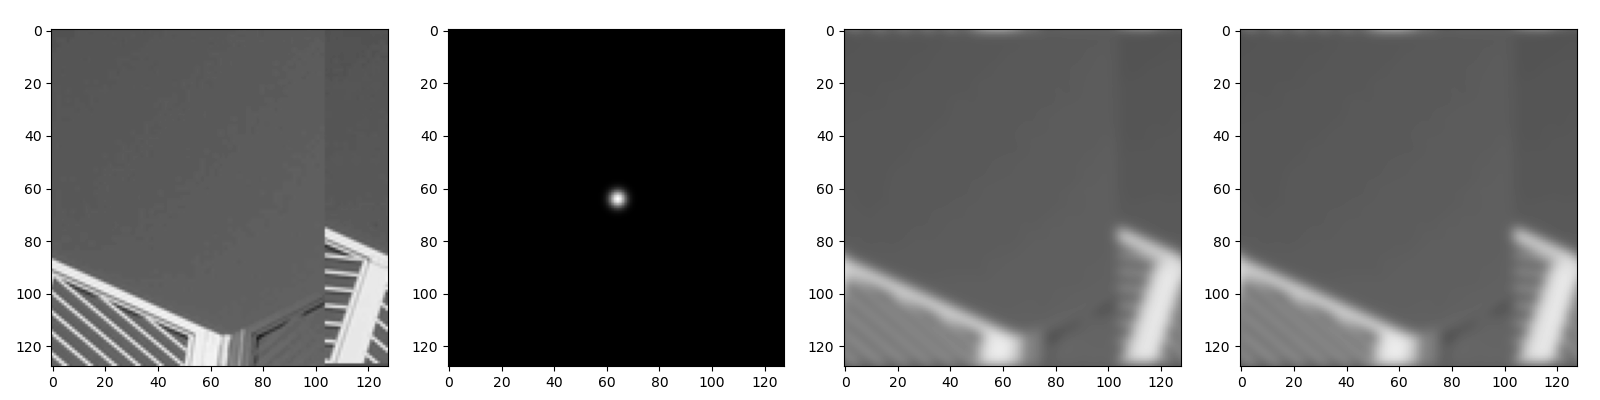

In [13]:
# Using inplace C2C VkFFT on-the-fly transform

# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))

k_gpu = fftn(g_gpu, g_gpu, ndim=2)

app = VkFFTApp(d_gpu.shape, dtype=np.complex64, queue=cq, ndim=2, inplace=True,convolve=True, convolve_conj=0)
gd = app.fft(d_gpu,convolve_kernel=k_gpu).get().real
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(d[n//2], cmap='gray',vmin=0,vmax=255)
plt.subplot(142)
plt.imshow(np.fft.fftshift(g)[n//2], cmap='gray')
plt.subplot(143)
plt.imshow(gd[n//2], cmap='gray',vmin=0,vmax=255)
plt.subplot(144)
plt.imshow(gd_np[n//2], cmap='gray',vmin=0,vmax=255)
plt.tight_layout()

np.allclose(gd, gd_np)

VkFFTApp[OpenCL]:(128,128,128)   C2C/s/o [-rr] [011] buf=    0       0  


True

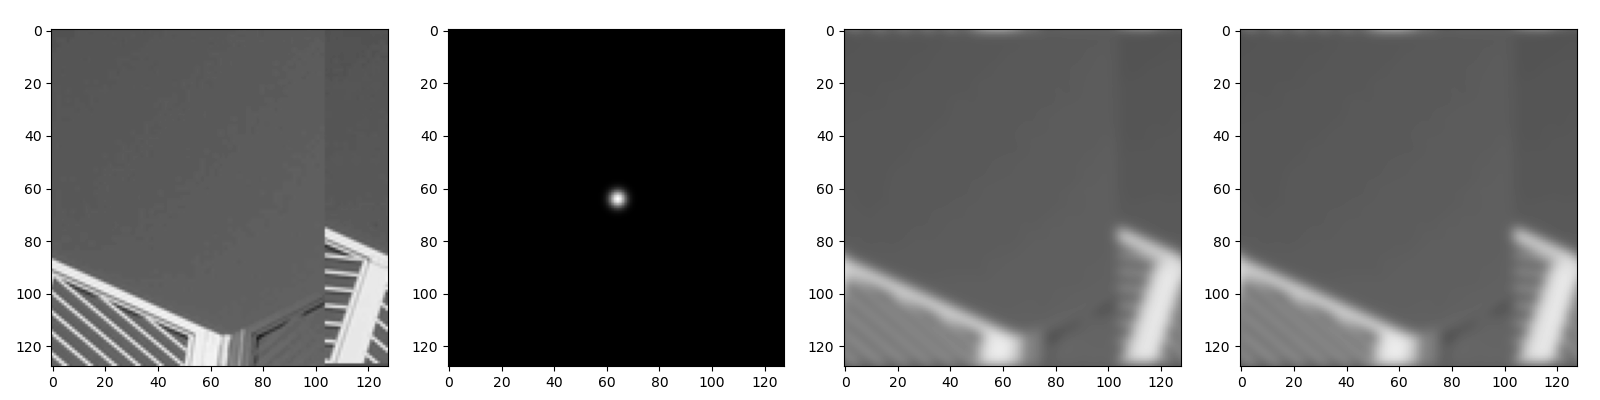

In [14]:
# Using out-of-place C2C VkFFT on-the-fly transform

# move data to GPU
d_gpu = cla.to_device(cq, d.astype(np.complex64))
g_gpu = cla.to_device(cq, g.astype(np.complex64))
gd_gpu = cla.empty_like(d_gpu)

k_gpu = fftn(g_gpu, g_gpu, ndim=2)

app = VkFFTApp(d_gpu.shape, dtype=np.complex64, queue=cq, ndim=2, inplace=False,convolve=True, convolve_conj=0)
gd = app.fft(d_gpu, gd_gpu,convolve_kernel=k_gpu).get().real
print(app, app.get_tmp_buffer_str())

plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(d[n//2], cmap='gray',vmin=0,vmax=255)
plt.subplot(142)
plt.imshow(np.fft.fftshift(g)[n//2], cmap='gray')
plt.subplot(143)
plt.imshow(gd[n//2], cmap='gray',vmin=0,vmax=255)
plt.subplot(144)
plt.imshow(gd_np[n//2], cmap='gray',vmin=0,vmax=255)
plt.tight_layout()

np.allclose(gd, gd_np)